In [1]:

!pip install timm medmnist torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 7.4 MB/s eta 0:00:00


In [13]:
from torchvision.models import shufflenet_v2_x1_0
import torch.nn as nn

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import timm
import numpy as np
import random
from medmnist import PneumoniaMNIST
from torchmetrics.classification import Accuracy
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [21]:
BATCH_SIZE = 16
LR = 1e-4
EPOCHS = 30
IMG_SIZE = 224
PATIENCE = 5



In [22]:
IMG_SIZE = 224
BATCH_SIZE = 16

train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Grayscale(num_output_channels=3),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [5]:
train_ds = PneumoniaMNIST(split="train", transform=train_tfms, download=True)
val_ds   = PneumoniaMNIST(split="val", transform=val_tfms, download=True)
test_ds  = PneumoniaMNIST(split="test", transform=val_tfms, download=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 4.17M/4.17M [00:01<00:00, 3.42MB/s]


In [23]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [24]:
def create_shufflenet():
    model = shufflenet_v2_x1_0(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model


In [14]:
def get_model(model_name):
    if model_name == "shufflenet_v2":
        model = shufflenet_v2_x1_0(weights="IMAGENET1K_V1")
        model.fc = nn.Linear(model.fc.in_features, 2)
    else:
        model = timm.create_model(model_name, pretrained=True, num_classes=2)
    return model.to(device)


In [25]:
def train_model(model, epochs=30):

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    early_stopper = EarlyStopping(patience=PATIENCE)

    for epoch in range(epochs):

        # ---- TRAIN ----
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # ---- VALIDATION ----
        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.squeeze().long().to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= total
        val_acc = correct / total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
              f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        early_stopper(val_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered")
            break

    return model, history


In [26]:
model = create_shufflenet()
model, history = train_model(model, epochs=EPOCHS)


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


100%|██████████| 8.79M/8.79M [00:00<00:00, 60.5MB/s]


Epoch [1/30] Train Loss: 0.3713 | Val Loss: 0.2125 | Train Acc: 0.8940 | Val Acc: 0.9466
Epoch [2/30] Train Loss: 0.1510 | Val Loss: 0.1261 | Train Acc: 0.9518 | Val Acc: 0.9618
Epoch [3/30] Train Loss: 0.1212 | Val Loss: 0.0748 | Train Acc: 0.9584 | Val Acc: 0.9771
Epoch [4/30] Train Loss: 0.1017 | Val Loss: 0.0601 | Train Acc: 0.9650 | Val Acc: 0.9790
Epoch [5/30] Train Loss: 0.0920 | Val Loss: 0.0686 | Train Acc: 0.9684 | Val Acc: 0.9752
Epoch [6/30] Train Loss: 0.0663 | Val Loss: 0.0571 | Train Acc: 0.9760 | Val Acc: 0.9771
Epoch [7/30] Train Loss: 0.0766 | Val Loss: 0.0861 | Train Acc: 0.9726 | Val Acc: 0.9714
Epoch [8/30] Train Loss: 0.0613 | Val Loss: 0.0590 | Train Acc: 0.9764 | Val Acc: 0.9752
Epoch [9/30] Train Loss: 0.0668 | Val Loss: 0.0578 | Train Acc: 0.9771 | Val Acc: 0.9809
Epoch [10/30] Train Loss: 0.0476 | Val Loss: 0.0486 | Train Acc: 0.9822 | Val Acc: 0.9809
Epoch [11/30] Train Loss: 0.0400 | Val Loss: 0.0862 | Train Acc: 0.9877 | Val Acc: 0.9695
Epoch [12/30] Train

In [27]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))




Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.71      0.82       234
           1       0.85      1.00      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.85      0.87       624
weighted avg       0.90      0.89      0.88       624



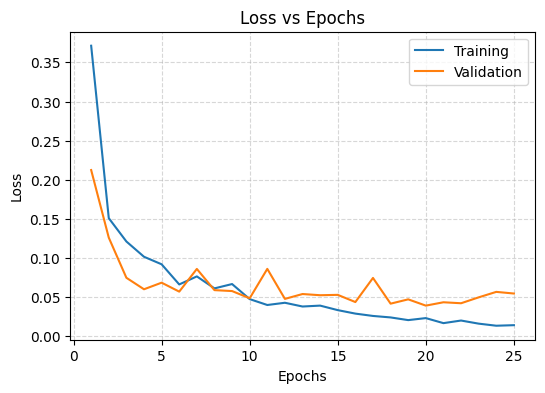

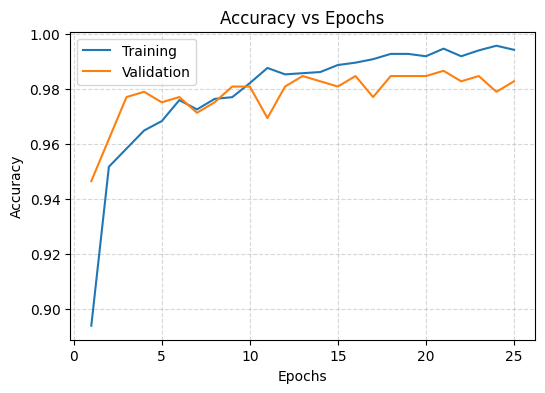

In [31]:
import matplotlib.pyplot as plt

def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Plot Loss
plot_metric(history["train_loss"], history["val_loss"],
            "Loss vs Epochs", "Loss")

# Plot Accuracy
plot_metric(history["train_acc"], history["val_acc"],
            "Accuracy vs Epochs", "Accuracy")

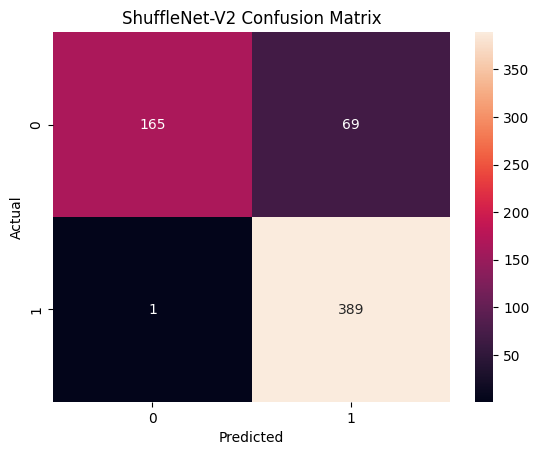

In [28]:
cm = confusion_matrix(y_true, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.title("ShuffleNet-V2 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()